# Proyek Klasifikasi Gambar: Scientific Image
- **Nama:** Jihan Aurelia
- **Email:** 18222001@std.stei.itb.ac.id
- **ID Dicoding:** MC002D5X2442

## Import Semua Packages/Library yang Digunakan

In [1]:
# =============================================================================
# 1. Reproducibility: set seeds, enforce determinism
# =============================================================================
import os
import random
import numpy as np
import tensorflow as tf

RANDOM_STATE = 1997

# OS‐level determinism
os.environ['PYTHONHASHSEED']    = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'

# Seed all RNGs
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Force single‐threaded execution in TF
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)


# =============================================================================
# 2. Standard library: filesystem, downloading, and OS operations
# =============================================================================
import zipfile
import shutil
from pathlib import Path

import gdown


# =============================================================================
# 3. Numerical & data handling
# =============================================================================
import pandas as pd
from tqdm.notebook import tqdm


# =============================================================================
# 4. Image I/O & processing
# =============================================================================
import cv2
from PIL import Image
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


# =============================================================================
# 5. Visualization
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import seaborn as sns
%matplotlib inline


# =============================================================================
# 6. TensorFlow / Keras
# =============================================================================
from tensorflow.keras import Model, layers, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Pre-trained models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121


# =============================================================================
# 7. Scikit-learn
# =============================================================================
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jihanaurelia","key":"4f0277bd52ef0aea4ab1913386024fe4"}'}

In [4]:
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
!kaggle datasets download -d rushilprajapati/data-final
if not os.path.exists('sci_img'):
    os.makedirs('sci_img')
!unzip data-final -d sci_img

Streaming output truncated to the last 5000 lines.
  inflating: sci_img/data/Non-scientific/image_1006.jpg  
  inflating: sci_img/data/Non-scientific/image_1007.jpg  
  inflating: sci_img/data/Non-scientific/image_1008.jpg  
  inflating: sci_img/data/Non-scientific/image_1009.jpg  
  inflating: sci_img/data/Non-scientific/image_101.jpg  
  inflating: sci_img/data/Non-scientific/image_1010.jpg  
  inflating: sci_img/data/Non-scientific/image_1011.jpg  
  inflating: sci_img/data/Non-scientific/image_1012.jpg  
  inflating: sci_img/data/Non-scientific/image_1013.jpg  
  inflating: sci_img/data/Non-scientific/image_1014.jpg  
  inflating: sci_img/data/Non-scientific/image_1015.jpg  
  inflating: sci_img/data/Non-scientific/image_1016.jpg  
  inflating: sci_img/data/Non-scientific/image_1017.jpg  
  inflating: sci_img/data/Non-scientific/image_1018.jpg  
  inflating: sci_img/data/Non-scientific/image_1019.jpg  
  inflating: sci_img/data/Non-scientific/image_102.jpg  
  inflating: sci_img/da

### **Poin:**

> "Gambar-gambar pada dataset asli memiliki resolusi yang tidak seragam (Tanpa preprocessing)"



In [5]:
def check_resolutions(dataset_path):
    """
    Checks and prints resolutions of images in a dataset.

    Args:
        dataset_path: Path to the dataset directory.
    """
    resolutions = set()
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    img = cv2.imread(file_path)
                    height, width, _ = img.shape
                    resolutions.add((width, height))
                except Exception as e:
                    print(f"Error reading image {file_path}: {e}")
    print("Unique resolutions in dataset:", resolutions)

In [6]:
dataset_path = '/content/sci_img/data'  # Replace with your dataset path
check_resolutions(dataset_path)

Unique resolutions in dataset: {(140, 43), (185, 194), (198, 213), (285, 281), (339, 252), (802, 99), (70, 64), (184, 86), (138, 119), (130, 115), (383, 295), (249, 215), (375, 440), (148, 132), (199, 214), (219, 192), (326, 26), (292, 33), (83, 39), (411, 362), (436, 306), (274, 244), (73, 74), (152, 367), (375, 67), (2101, 1943), (233, 212), (286, 218), (159, 34), (104, 98), (256, 195), (461, 335), (74, 75), (155, 149), (139, 55), (279, 215), (85, 84), (166, 158), (172, 52), (298, 48), (170, 128), (257, 196), (255, 352), (457, 221), (303, 163), (201, 152), (206, 230), (207, 195), (367, 184), (167, 159), (191, 187), (70, 77), (339, 85), (112, 43), (385, 52), (272, 32), (171, 129), (230, 35), (148, 145), (121, 128), (200, 192), (207, 51), (151, 150), (186, 28), (551, 386), (218, 60), (438, 329), (104, 75), (230, 71), (215, 171), (154, 161), (173, 174), (427, 319), (439, 330), (265, 28), (177, 144), (236, 230), (724, 542), (123, 173), (229, 191), (484, 72), (246, 280), (340, 58), (206, 

### **Poin:**
> "Dataset yang digunakan berisi minimal 10000 gambar."


Gabungkan Data Train dan Data Test ke Direktori yang Sama

In [7]:
import os
import shutil

# Direktori sumber
dataset = '/content/sci_img/data'

# Direktori tujuan
destination_dir = '/content/sci_dataset'

# Membuat direktori tujuan jika belum ada
os.makedirs(destination_dir, exist_ok=True)

# Fungsi untuk menyalin gambar dan memberi label
def copy_images(src_dir, dest_dir):
    # Iterasi melalui semua kategori/sub-folder di dalam direktori
    for category in os.listdir(src_dir):
        category_path = os.path.join(src_dir, category)

        # Pastikan hanya folder yang diproses
        if os.path.isdir(category_path):
            for image_name in os.listdir(category_path):
                image_path = os.path.join(category_path, image_name)

                # Tentukan jalur tujuan dengan menambahkan label pada nama file
                dest_image_path = os.path.join(dest_dir, f"{category}_{image_name}")

                # Salin gambar ke direktori tujuan
                shutil.copy(image_path, dest_image_path)

# Salin gambar dari direktori pelatihan
copy_images(dataset, destination_dir)

print("Penggabungan gambar selesai!")


Penggabungan gambar selesai!


In [8]:
import os

# Direktori tujuan (folder dataset)
dataset_dir = '/content/sci_dataset'

# Menghitung jumlah gambar di dalam folder dataset
image_count = 0
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        # Memeriksa apakah file memiliki ekstensi gambar (misalnya .jpg, .jpeg, .png)
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_count += 1

print(f"Jumlah gambar di dalam folder dataset: {image_count}")


Jumlah gambar di dalam folder dataset: 19105


### **Poin:**


> "Memiliki 3 buah kelas atau lebih."



In [9]:
import os

# Direktori dataset
dataset_dir = '/content/sci_dataset'

# Menampilkan distribusi gambar untuk setiap label
label_distribution = {}

# Iterasi setiap gambar dalam folder dataset
for image_name in os.listdir(dataset_dir):
    # Memastikan hanya file gambar yang diproses
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Mengambil label dari nama file (misalnya 'buildings_0.jpg' -> 'buildings')
        label = image_name.split('_')[0]

        # Menambahkan label ke distribusi
        if label in label_distribution:
            label_distribution[label] += 1
        else:
            label_distribution[label] = 1

# Menampilkan hasil distribusi
for label, count in label_distribution.items():
    print(f"Label '{label}': {count} gambar")


Label 'FACS': 1070 gambar
Label 'Macroscopy': 4462 gambar
Label 'Microscopy': 1509 gambar
Label 'Non-scientific': 5010 gambar
Label 'Histopathology': 5179 gambar
Label 'Blot-Gel': 1875 gambar


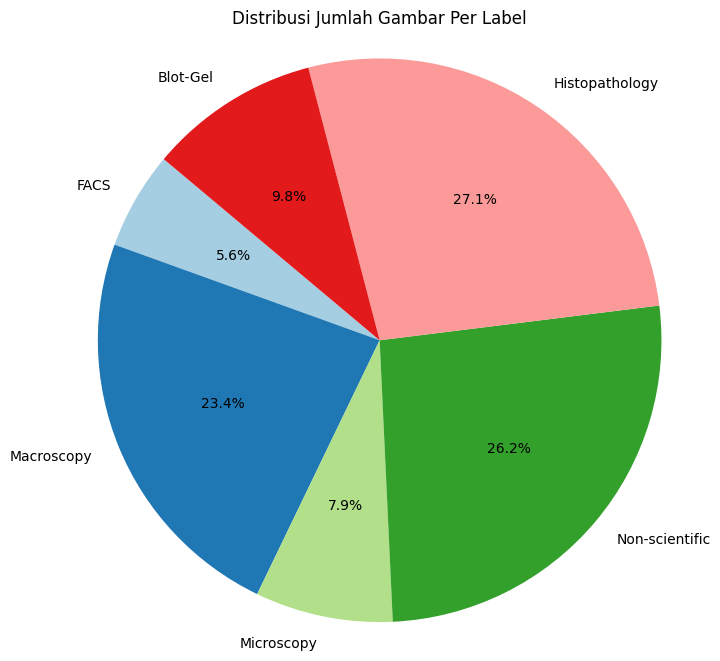

In [10]:
import os
import matplotlib.pyplot as plt

# Direktori dataset
dataset_dir = '/content/sci_dataset'

# Menampilkan distribusi gambar untuk setiap label
label_distribution = {}

# Iterasi setiap gambar dalam folder dataset
for image_name in os.listdir(dataset_dir):
    # Memastikan hanya file gambar yang diproses
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Mengambil label dari nama file (misalnya 'buildings_0.jpg' -> 'buildings')
        label = image_name.split('_')[0]

        # Menambahkan label ke distribusi
        if label in label_distribution:
            label_distribution[label] += 1
        else:
            label_distribution[label] = 1

# Plot pie chart
labels = list(label_distribution.keys())
sizes = list(label_distribution.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribusi Jumlah Gambar Per Label')
plt.axis('equal')  # Untuk memastikan pie chart berbentuk lingkaran
plt.show()


## **Splitting**

> Dataset Dibagi Menjadi Train Set, Test Set dan Validation Set.

In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Direktori dataset
dataset_dir = '/content/sci_dataset'

# Direktori tujuan untuk train, validation, test set
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

# Membuat direktori tujuan jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Menampilkan distribusi gambar untuk setiap label
label_distribution = {}

# Mengumpulkan gambar untuk pembagian
image_paths = []

for image_name in os.listdir(dataset_dir):
    # Memastikan hanya file gambar yang diproses
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        label = image_name.split('_')[0]
        label_path = os.path.join(dataset_dir, image_name)
        image_paths.append((label, label_path))

# Membagi data menjadi Train, Validation, dan Test set
train_paths, temp_paths = train_test_split(image_paths, test_size=0.2, random_state=42)  # 80% train
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)  # 50% validation, 50% test

# Fungsi untuk menyalin gambar ke direktori tujuan
def copy_images(image_paths, dest_dir):
    for label, image_path in image_paths:
        label_dir = os.path.join(dest_dir, label)
        os.makedirs(label_dir, exist_ok=True)  # Membuat folder untuk label jika belum ada
        shutil.copy(image_path, label_dir)

# Salin gambar ke dalam Train, Validation, dan Test Set
copy_images(train_paths, train_dir)
copy_images(val_paths, val_dir)
copy_images(test_paths, test_dir)

print("Dataset berhasil dibagi menjadi Train Set, Validation Set, dan Test Set.")


Dataset berhasil dibagi menjadi Train Set, Validation Set, dan Test Set.


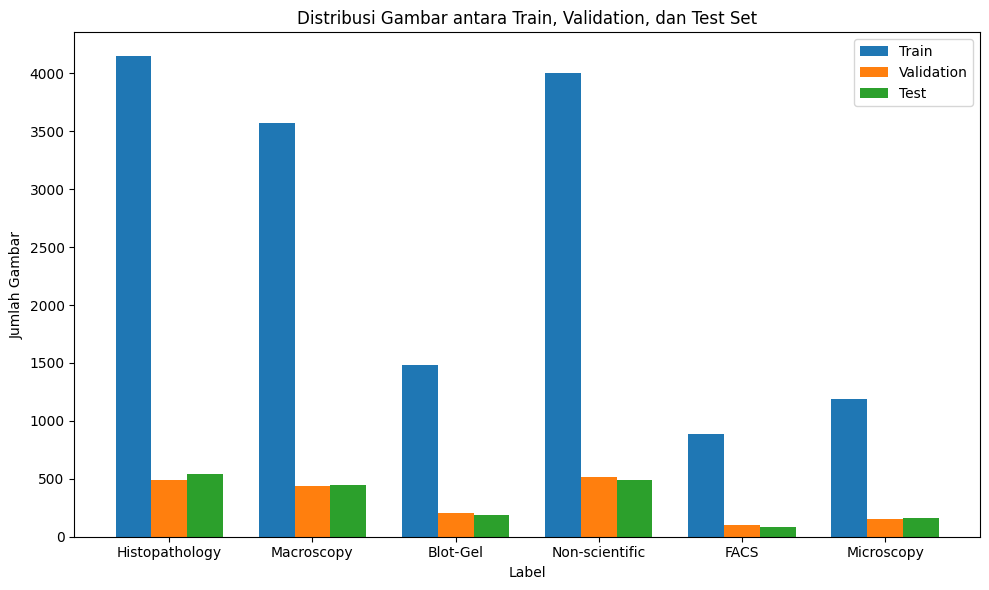

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Direktori dataset setelah pembagian
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

# Menampilkan distribusi gambar untuk setiap label
labels = os.listdir(train_dir)

# Menyimpan jumlah gambar untuk Train, Validation, dan Test
train_counts = []
val_counts = []
test_counts = []

for label in labels:
    # Menghitung jumlah gambar di setiap folder
    train_label_dir = os.path.join(train_dir, label)
    val_label_dir = os.path.join(val_dir, label)
    test_label_dir = os.path.join(test_dir, label)

    # Memastikan hanya folder yang diproses
    if os.path.isdir(train_label_dir):
        train_counts.append(len([img for img in os.listdir(train_label_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]))
        val_counts.append(len([img for img in os.listdir(val_label_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]))
        test_counts.append(len([img for img in os.listdir(test_label_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]))

# Menyiapkan plot
x = np.arange(len(labels))  # Posisi untuk setiap label
width = 0.25  # Lebar setiap batang

# Membuat bar plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, train_counts, width, label='Train', color='tab:blue')
rects2 = ax.bar(x, val_counts, width, label='Validation', color='tab:orange')
rects3 = ax.bar(x + width, test_counts, width, label='Test', color='tab:green')

# Menambahkan label dan judul
ax.set_xlabel('Label')
ax.set_ylabel('Jumlah Gambar')
ax.set_title('Distribusi Gambar antara Train, Validation, dan Test Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Menyesuaikan layout dan menampilkan plot
plt.tight_layout()
plt.show()


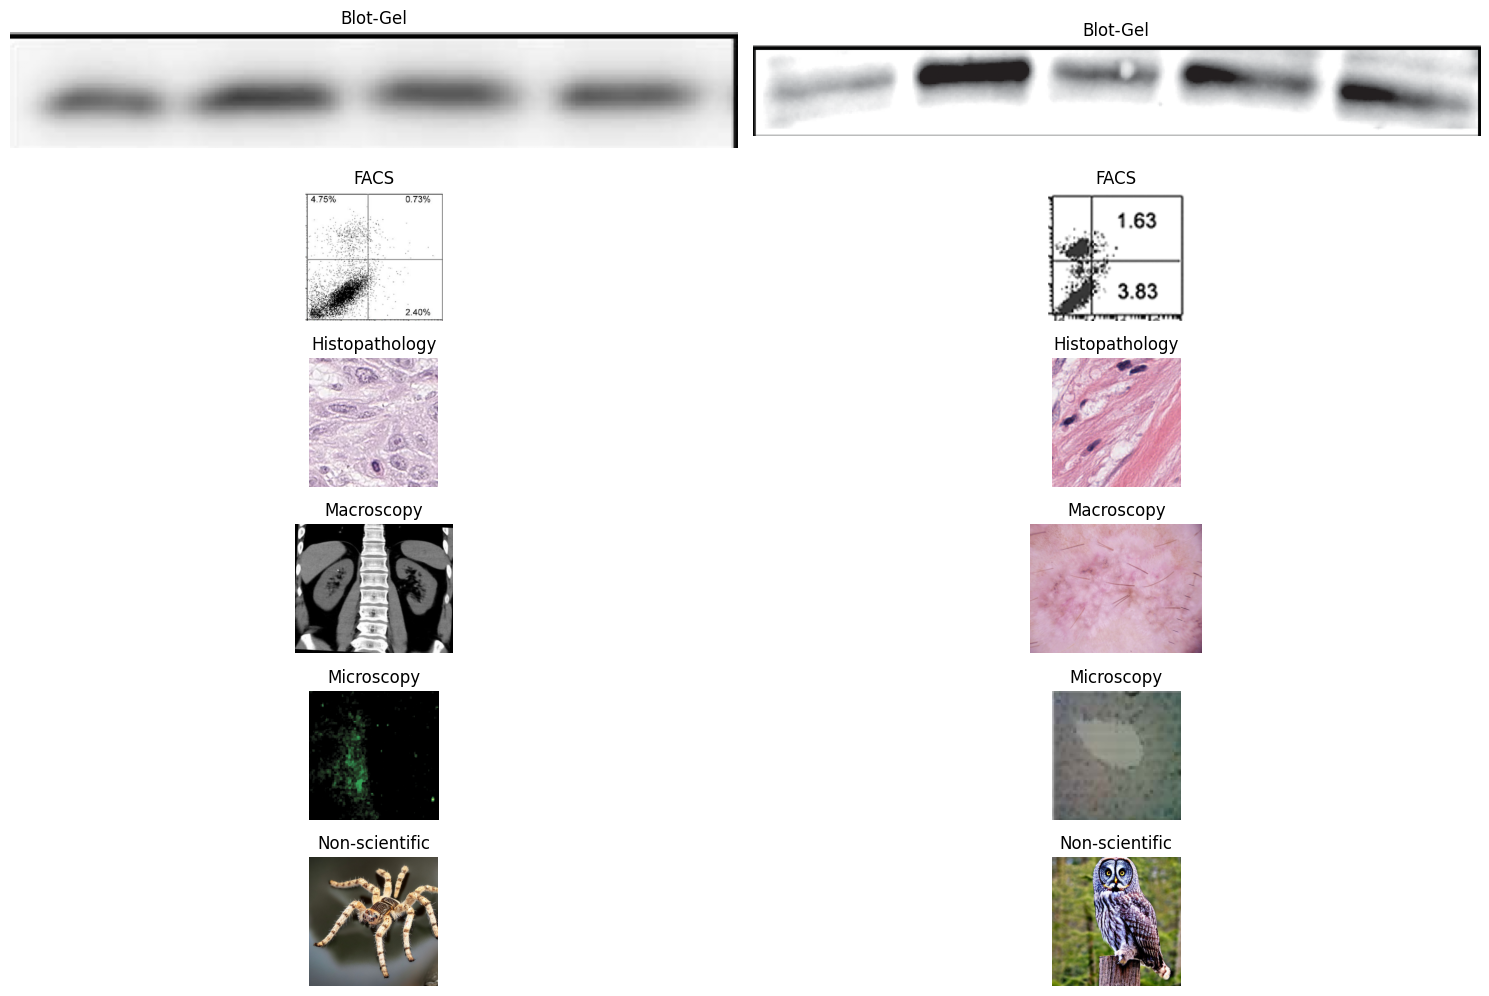

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Update dataset_dir to point to your dataset directory containing the images.
# The original code was using a folder without the image samples.
dataset_dir = '/content/sci_img/data'

# Daftar kelas
class_names = ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']

# Menampilkan 2 gambar per kelas
plt.figure(figsize=(15, 10))  # Sesuaikan ukuran figure sesuai kebutuhan

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_dir, class_name) # Correctly form the class directory path

    # Check if the directory exists
    if os.path.exists(class_dir):
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Mengambil 2 gambar secara acak
        random_images = random.sample(image_files, min(2, len(image_files))) # Handle cases with fewer than 2 images

        for j, image_file in enumerate(random_images):
            image_path = os.path.join(class_dir, image_file)
            img = mpimg.imread(image_path)

            plt.subplot(len(class_names), 2, i * 2 + j + 1)  # Menentukan posisi subplot
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')  # Menonaktifkan sumbu
    else:
        print(f"Directory not found: {class_dir}") # Print a message if directory is not found


plt.tight_layout()  # Menyesuaikan layout agar tidak tumpang tindih
plt.show()

## Modelling

In [15]:
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Membekukan layer base model agar tidak dilatih ulang
base_model.trainable = False

# Membuat model Sequential
model = models.Sequential()

# Menambahkan pre-trained VGG16 sebagai fitur ekstraktor
# Input shape is set here to match VGG16's expected input
model.add(layers.InputLayer(input_shape=(224, 224, 3))) # Define input shape explicitly
model.add(base_model)

# Menambahkan layer Conv2D dan Pooling Layer setelah pre-trained model
# Adjusted the architecture to avoid excessive downsampling:
# Menambahkan layer Conv2D dan Pooling Layer setelah pre-trained model
# Adjusted the architecture to avoid excessive downsampling:
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=base_model.output_shape[1:], padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# Removed one MaxPooling2D layer to prevent 1x1 feature maps
# model.add(layers.MaxPooling2D((2, 2))) # This line was removed
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2))) # This line was removed or change the pool size to (1,1)

# Flatten layer untuk mengubah data 3D menjadi 1D
model.add(layers.Flatten())

# Output layer dengan jumlah kelas sesuai dataset
model.add(layers.Dense(6, activation='softmax'))  # Ganti 6 dengan jumlah kelas Anda

# Menyusun model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan summary model
model.summary()

# Callback untuk menyimpan model terbaik dan menghentikan training jika tidak ada peningkatan
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         6,918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,961,446 (57.07 MB)

 Trainable params: 246,758 (963.90 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### **Point:**


> "Mengimplementasikan Callback"

> Skor > 0.95



In [18]:
# Menyiapkan ImageDataGenerator untuk augmentasi gambar dan memuat data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan flow_from_directory untuk memuat data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Melatih model menggunakan fit_generator
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

# Menilai model pada test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Menampilkan akurasi training dan validation selama epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

Found 15284 images belonging to 6 classes.
Found 1910 images belonging to 6 classes.
Found 1911 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7545 - loss: 0.6399
Epoch 1: val_loss improved from inf to 0.22246, saving model to best_model.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.7550 - loss: 0.6388 - val_accuracy: 0.9340 - val_loss: 0.2225
Epoch 2/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9386 - loss: 0.1882
Epoch 2: val_loss improved from 0.22246 to 0.14959, saving model to best_model.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.9386 - loss: 0.1881 - val_accuracy: 0.9518 - val_loss: 0.1496
Epoch 3/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9554 - loss: 0.1336
Epoch 3: val_loss improved from 0.14959 to 0.13845, saving model to best_model.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9554 - loss: 0.1335 - val_accuracy: 0.9581 - val_loss: 0.1384
Epoch 4/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9606 - loss: 0.1197
Epoch 4: val_loss improved from 0.13845 to 0.13016, saving model to best_model.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.9606 - loss: 0.1197 - val_accuracy: 0.9644 - val_loss: 0.1302
Epoch 5/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9580 - loss: 0.1193
Epoch 5: val_loss improved from 0.13016 to 0.11642, saving model to best_model.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.9580 - loss: 0.1193 - val_accuracy: 0.9681 - val_loss: 0.1164
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.9790 - loss: 0.0664
Test Accuracy: 0.9665096998214722


In [19]:
# Assuming 'history' is the object returned by model.fit
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

Train Accuracy: 0.9605469703674316
Validation Accuracy: 0.9680628180503845


## Evaluasi dan Visualisasi

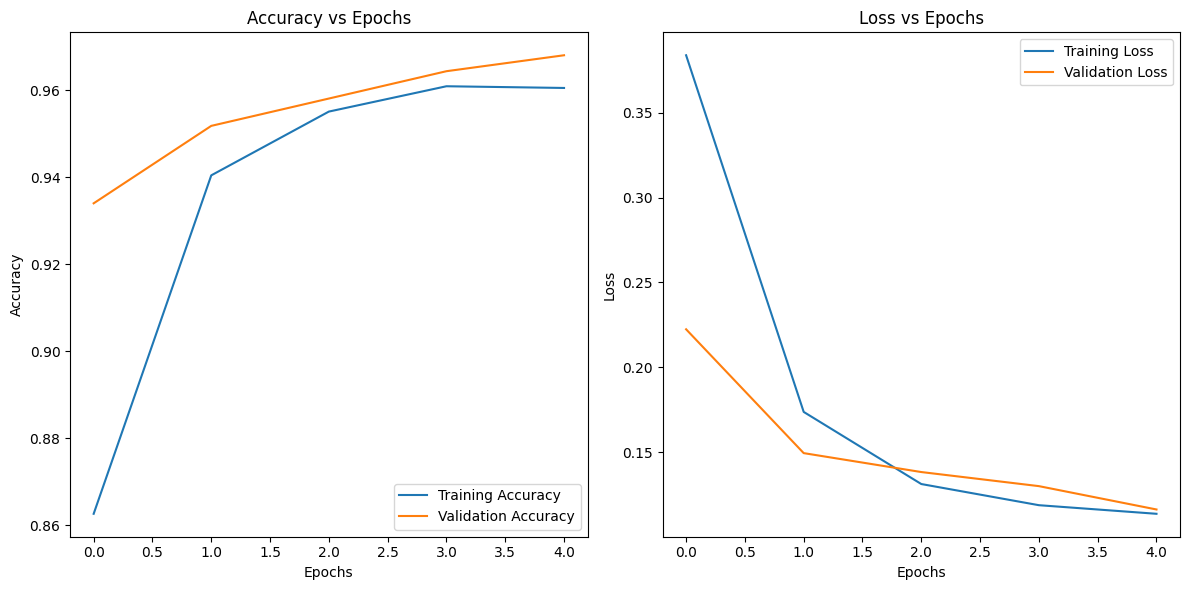

In [20]:
# Function to plot accuracy and loss
def plot_accuracy_loss(history):
    # Extract accuracy and loss data from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting accuracy
    plt.figure(figsize=(12, 6))

    # Subplot for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Subplot for loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot accuracy and loss after training
plot_accuracy_loss(history)

In [21]:
y_pred=model.predict(test_generator)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

report = classification_report(y_true, y_pred_classes, target_names=['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific'])
print(report)

60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step
                precision    recall  f1-score   support

      Blot-Gel       0.94      0.98      0.96       186
          FACS       0.95      1.00      0.98        83
Histopathology       0.98      1.00      0.99       539
    Macroscopy       0.97      0.97      0.97       449
    Microscopy       0.91      0.75      0.82       162
Non-scientific       0.98      0.99      0.98       492

      accuracy                           0.97      1911
     macro avg       0.96      0.95      0.95      1911
  weighted avg       0.97      0.97      0.97      1911



## Konversi Model

In [22]:
import tensorflow as tf
import pathlib

# Anggap 'model' adalah model yang telah Anda latih
# Tentukan direktori tempat Anda ingin menyimpan SavedModel
saved_model_dir = './saved_model/'

# Simpan model dalam format SavedModel
tf.saved_model.save(model, saved_model_dir)
print(f"Model disimpan di {saved_model_dir}")


Model disimpan di ./saved_model/


In [23]:
# Konversi model SavedModel ke format TensorFlow Lite (TFLite)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)  # Model SavedModel path
tflite_model = converter.convert()

# Tentukan path untuk menyimpan file TFLite
tflite_model_path = pathlib.Path('./tflite/model.tflite')

# Create the 'tflite' directory if it doesn't exist
os.makedirs(tflite_model_path.parent, exist_ok=True)

# Simpan model TFLite
tflite_model_path.write_bytes(tflite_model)
print(f"Model TFLite disimpan di {tflite_model_path}")

Model TFLite disimpan di tflite/model.tflite


In [36]:
# !pip install tensorflowjs

In [29]:
import tensorflowjs as tfjs

# Tentukan path untuk menyimpan model TFJS
tfjs_model_dir = './tfjs_model/'

# Konversi model dari SavedModel ke format TensorFlow.js
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model TensorFlow.js disimpan di {tfjs_model_dir}")


failed to lookup keras version from the file,
    this is likely a weight only file
Model TensorFlow.js disimpan di ./tfjs_model/


## Inference (Optional)

In [31]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Path gambar yang ingin diproses
img_path = '/content/test/Blot-Gel/Blot-Gel_010000 (5).png'

# Memuat dan Preprocessing Gambar
def images_preprocessing(filenames):
    image_tensors = []
    for filename in filenames:
        # Membaca gambar dan mendekode gambar dengan tf.io.decode_image
        # Resize sesuai input VGG16, yaitu (224, 224)
        img = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img)

        # Preprocessing sesuai dengan VGG16
        img_array = preprocess_input(img_array)

        # Menambahkan dimensi untuk batch
        image_tensor = np.expand_dims(img_array, axis=0)

        # Menambahkan gambar yang sudah diproses ke dalam list
        image_tensors.append(image_tensor)

    # Menggabungkan semua gambar menjadi satu batch
    batch_tensor = np.concatenate(image_tensors, axis=0)
    return batch_tensor

# Daftar gambar yang ingin diproses (hanya satu gambar dalam hal ini)
filenames = [img_path]

# Mendapatkan tensor gambar yang sudah diproses
image_tensors = images_preprocessing(filenames=filenames)

# Load the saved model
loaded_model = tf.saved_model.load('./saved_model/')  # Ganti dengan path model yang sesuai

# Akses fungsi inferensi menggunakan atribut .signatures
infer = loaded_model.signatures["serving_default"]

# Perform inference directly on the preprocessed image
predictions = infer(inputs=image_tensors)  # Pass the image directly to the model

# Mendapatkan kelas yang diprediksi dari tensor output
# Mengakses 'output_0' dari hasil prediksi
predicted_class = np.argmax(predictions['output_0'].numpy()[0])

# Print the predicted class
class_names = ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']  # Nama kelas sesuai dengan dataset
print("Predicted class:", class_names[predicted_class])

Predicted class: Non-scientific


In [32]:
import shutil
from google.colab import files

# Tentukan folder yang ingin diunduh dan nama zip file
folder_path = '/content/saved_model'  # Ganti dengan path folder Anda
zip_path = 'C:/Users/Jihan Aurelia/Downloads/saved_model.zip'  # Nama file zip yang diinginkan

# Membuat file zip dari folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

# Mengunduh file zip ke lokal
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
import shutil

# Tentukan folder yang ingin diunduh dan nama zip file
folder_path = '/content/tfjs_model'  # Ganti dengan path folder Anda
zip_path = 'C:/Users/Jihan Aurelia/Downloads/tfjs_model.zip'  # Nama file zip yang diinginkan

# Membuat file zip dari folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

# Mengunduh file zip ke lokal
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
import shutil

# Tentukan folder yang ingin diunduh dan nama zip file
folder_path = '/content/tflite'  # Ganti dengan path folder Anda
zip_path = 'C:/Users/Jihan Aurelia/Downloads/tflite.zip'  # Nama file zip yang diinginkan

# Membuat file zip dari folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

# Mengunduh file zip ke lokal
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# !pip freeze > requirements.txt